In [8]:
import numpy as np
import random
import copy
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

HBond pattern: 

[ True  True  True False  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True]


<IPython.core.display.Javascript object>


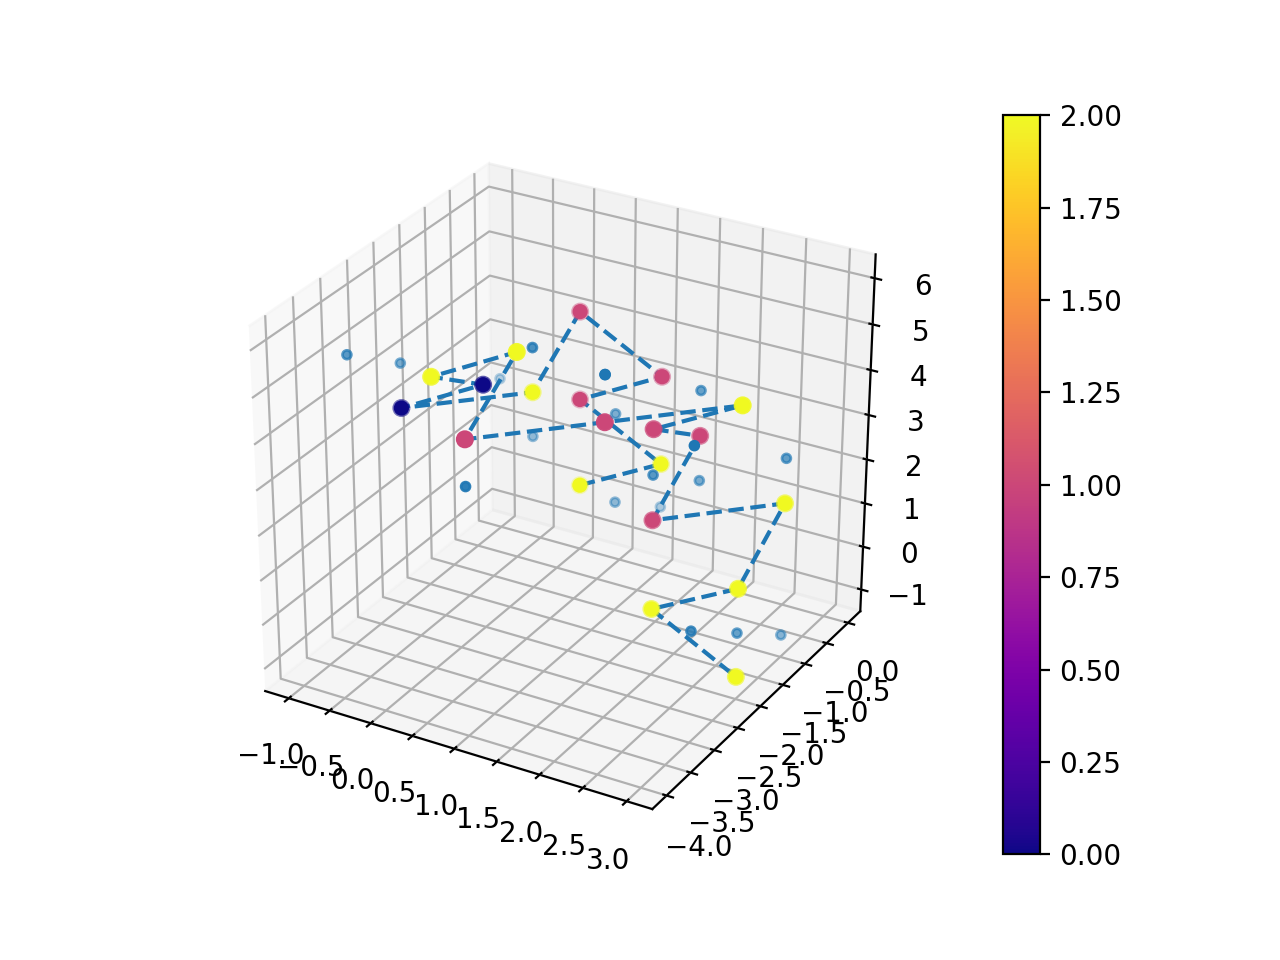

In [9]:
CONNECTED = True
RUNPARAMS = [1, 0.80, 0, 0, 0, 0]
CHECKSTART = 1e4
CHECKFREQ = 1e3
HBPARAM = - 0.30
SCPARAM =  - 0.9
STIFFPARAM = 0.2

Preview = True

#SIDECHAINS = np.ones((3,3),dtype = np.double)

SIDECHAINS = np.array([[1.0,0.5,0.0],[0.5,0.5,0.0],[0.0,0.0,0.25]],dtype = np.double)
LEN = 20

def getEnergy(Coordinates,Contacts):
    EnergyTotal = 0
    for residue in range(len(Sequence)):
        NeighEnergy = 0
        AngleEnergy = 0
        sc = Sequence[residue]
        x0, y0, z0 = Coordinates[residue]
        n = 0
        checks = (1, 0, 1)
        AdjecentPoints = np.zeros((12, 3), dtype=np.int)
        while (n < len(AdjecentPoints)):
            for x, cx in zip((x0 - 1, x0, x0 + 1), checks):
                for y, cy in zip((y0 - 1, y0, y0 + 1), checks):
                    for z, cz in zip((z0 - 1, z0, z0 + 1), checks):
                        if cx + cy + cz == 2:
                            AdjecentPoints[n] = (x, y, z)
                            n += 1
        NeighboursID = []
        for n in range(12):
            x, y, z = AdjecentPoints[n, :]
            for m in range(len(Sequence)):
                x0 = Coordinates[m, 0]
                y0 = Coordinates[m, 1]
                z0 = Coordinates[m, 2]
                if (x == x0 and y == y0 and z == z0) and m != residue-1 and m != residue - 1 :
                    NeighboursID.append(m)
                    
        SideChainsEnergy = 0
        for neigh in NeighboursID:
            if  Contacts[residue][neigh]:
                scn = Sequence[neigh]
                NeighEnergy += SIDECHAINS[scn][sc]
        
        for neigh in NeighboursID:
            if neigh == residue + 2 or neigh == residue - 2:
                AngleEnergy += 1.0
         
        EnergyTotal += ((SCPARAM * NeighEnergy/2)  + (STIFFPARAM * AngleEnergy/2)) 
        #print(NeighEnergy,AngleEnergy)
        #H bond energy
        #Only for i + 4 residues
        
    IDlist = [i for i in range(len(Sequence))]
    HBondEnergy = 0
    while(len(IDlist) > 0):
        residue = IDlist.pop(random.choice(range(len(IDlist))))
        if CanHBond[residue] == True:
            x0, y0, z0 = Coordinates[residue]
            n = 0
            checks = (1, 0, 1)
            AdjecentPoints = np.zeros((12, 3), dtype=np.int)
            while (n < len(AdjecentPoints)):
                for x, cx in zip((x0 - 1, x0, x0 + 1), checks):
                    for y, cy in zip((y0 - 1, y0, y0 + 1), checks):
                        for z, cz in zip((z0 - 1, z0, z0 + 1), checks):
                            if cx + cy + cz == 2:
                                AdjecentPoints[n] = (x, y, z)
                                n += 1
            NeighboursID = []
            for n in range(12):
                x, y, z = AdjecentPoints[n, :]
                for m in range(len(Sequence)):
                    x0 = Coordinates[m, 0]
                    y0 = Coordinates[m, 1]
                    z0 = Coordinates[m, 2]
                    if (x == x0 and y == y0 and z == z0) and m != residue-1 and m != residue - 1 :
                        NeighboursID.append(m)
                HB = []
                for neigh in NeighboursID:
                    if CanHBond[neigh] and (neigh >= (residue + 4) or neigh <= (residue - 4)):
                        HB.append(neigh)
                if len(HB) > 0:
                    bond = random.choice(HB)  
                    CanHBond[residue] = False
                    HBondEnergy += 1.0
                    CanHBond[bond] = False
    EnergyTotal += (HBPARAM * HBondEnergy)    
        
    return EnergyTotal     

def getSideChainContacts(Coordinates,Contacts):
    for i in range(len(Sequence)):
        for j in range(i+1):
            if i != j:
                c1 = Coordinates[i]
                c2 = Coordinates[j]
                delta = c1 - c2
                if np.sum(abs(delta)) == 2:
                    Contacts[i][j] = Contacts[j][i] = True
                else:
                    Contacts[i][j] = Contacts[j][i] = False

def generateSequence(N,alphabet):
    sequence = random.choices(alphabet,weights=(1,2,3),k=N)
    return sequence

def generateChain(sequence):
    chain_coords = [[0,0,0]]
    for p in range(1,len(sequence)):
        Flag = True
        while(Flag):
            c1 = random.choice([-1,+1])
            c2 = random.choice([-1,+1])

            p1 = random.choice([0,1,2])
            nchoice = [0,1,2]
            nchoice.pop(p1)
            p2 = random.choice(nchoice)

            new_point = copy.deepcopy(chain_coords[p-1])
            new_point[p1] += c1
            new_point[p2] += c2

            if new_point not in chain_coords:
                Flag = False
                chain_coords.append(new_point)
            
    return chain_coords

###############   Initialization  #####################

Sequence = np.array(generateSequence(LEN,[0,1,2]),dtype = np.int)
ChainCoordinates = np.array(generateChain(Sequence),dtype = np.int)
CanHBond = np.array([True]*len(Sequence),dtype = np.bool_)
t_ChainCoordinates = copy.deepcopy(ChainCoordinates)

SideChainCoordinates = copy.deepcopy(ChainCoordinates)
for n in range(len(Sequence)):
    SideChainCoordinates[n][random.choice([0,1,2])] += random.choice([-1,1])
t_SideChainCoordinates = copy.deepcopy(SideChainCoordinates)

SideChainContacts = np.zeros((len(Sequence),len(Sequence)),dtype = np.bool_)

getSideChainContacts(SideChainCoordinates,SideChainContacts)
t_SideChainContacts = copy.deepcopy(SideChainContacts)

NewEnergy = getEnergy(ChainCoordinates,SideChainContacts)

Histogram = {NewEnergy:1}
lng = {NewEnergy:1}
EnergyList = [NewEnergy]
MovePattern = []
Snapshots = []
Configurations = [ChainCoordinates]
SideChainConfigurations = [SideChainCoordinates]
##########################
print('HBond pattern: \n')
print(CanHBond)

if Preview:    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    xdata = np.ones(len(Sequence),dtype = np.int)
    ydata = np.ones(len(Sequence),dtype = np.int)
    zdata = np.ones(len(Sequence),dtype = np.int)
    xdata2 = np.ones(len(Sequence),dtype = np.int)
    ydata2 = np.ones(len(Sequence),dtype = np.int)
    zdata2 = np.ones(len(Sequence),dtype = np.int)

    for n in range(len(Sequence)):
        xdata[n], ydata[n], zdata[n] = ChainCoordinates[n, :]
        xdata2[n], ydata2[n], zdata2[n] = SideChainCoordinates[n, :]
    p = ax.scatter3D(xdata, ydata, zdata, s = 30,c = Sequence,cmap = 'plasma')
    ax.scatter3D(xdata2, ydata2, zdata2, s = 10, c='tab:blue')
    ax.plot3D(xdata, ydata, zdata,'--')
    plt.colorbar(p)
    plt.show()

In [10]:
#################   Simulation ###############

MINUPDATE = 1e-8
MAXITER = 1e5
MOVES = ("PULL","SLINGSHOT")

while(RUNPARAMS[0] > MINUPDATE or RUNPARAMS[2] > MAXITER):
    WLACCEPT = False
    CONNECTED = False
    
    #MoveChoice = "SLINGSHOT"
    #MoveChoice = "PULL"
    
    MoveChoice = random.choice(MOVES)

    t_ChainCoordinates = copy.deepcopy(ChainCoordinates)
    t_SideChainCoordinates = copy.deepcopy(SideChainCoordinates)
    t_SideChainContacts = copy.deepcopy(SideChainContacts)



    if MoveChoice == "PULL":
        MovePattern.append(0)
        CONNECTED = True
        resID = random.choice(range(len(Sequence)))
        # pull move generator
        AdjecentPoints = np.zeros((12, 3), dtype=np.int)
        x0, y0, z0 = copy.deepcopy(ChainCoordinates[resID])
        n = 0
        checks = (1, 0, 1)

        while (n < len(AdjecentPoints)):
            for x, cx in zip((x0 - 1, x0, x0 + 1), checks):
                for y, cy in zip((y0 - 1, y0, y0 + 1), checks):
                    for z, cz in zip((z0 - 1, z0, z0 + 1), checks):
                        if cx + cy + cz == 2:
                            AdjecentPoints[n] = (x, y, z)
                            n += 1

        NotAvailable = []
        for n in range(12):
            x, y, z = AdjecentPoints[n, :]
            for m in range(len(Sequence)):
                x0 = ChainCoordinates[m, 0]
                y0 = ChainCoordinates[m, 1]
                z0 = ChainCoordinates[m, 2]
                if x == x0 and y == y0 and z == z0:
                    NotAvailable.append(n)
        AvailablePoints = np.delete(AdjecentPoints, NotAvailable, 0)
        del(AdjecentPoints)
        if len(AvailablePoints)>0:
        # print(AdjecentPoints,'\n')
        # print(AvailablePoints,'\n')
            if resID == 0:
                for n in range(1, len(Sequence)):
                    t_ChainCoordinates[n] = copy.deepcopy(ChainCoordinates[n - 1])
                t_ChainCoordinates[resID] = copy.deepcopy(random.choice(AvailablePoints))  
                t_SideChainCoordinates = copy.deepcopy(SideChainCoordinates)
                t_SideChainCoordinates[resID] = copy.deepcopy(t_ChainCoordinates[resID])
                t_SideChainCoordinates[resID][random.choice([0,1,2])] += random.choice([-1,1])
                getSideChainContacts(t_SideChainCoordinates,t_SideChainContacts)
            elif resID == (len(Sequence) - 1):
                for n in range(1, len(Sequence)):
                    t_ChainCoordinates[-n - 1] = copy.deepcopy(ChainCoordinates[-n])
                t_ChainCoordinates[resID] = copy.deepcopy(random.choice(AvailablePoints))  
                t_SideChainCoordinates = copy.deepcopy(SideChainCoordinates)
                t_SideChainCoordinates[resID] = copy.deepcopy(t_ChainCoordinates[resID])
                t_SideChainCoordinates[resID][random.choice([0,1,2])] += random.choice([-1,1])
                getSideChainContacts(t_SideChainCoordinates,t_SideChainContacts)
            else:            
                neighID = random.choice([resID + 1, resID - 1])
                NeighAdjecentPoints = np.zeros((12, 3), dtype=int)
                x0, y0, z0 = copy.deepcopy(ChainCoordinates[neighID])
                n = 0
                checks = (1, 0, 1)

                while (n < len(NeighAdjecentPoints)):
                    for x, cx in zip((x0 - 1, x0, x0 + 1), checks):
                        for y, cy in zip((y0 - 1, y0, y0 + 1), checks):
                            for z, cz in zip((z0 - 1, z0, z0 + 1), checks):
                                if cx + cy + cz == 2:
                                    NeighAdjecentPoints[n] = (x, y, z)
                                    n += 1

                NeighNotAvailable = []
                for n in range(12):
                    x, y, z = NeighAdjecentPoints[n, :]
                    for m in range(len(Sequence)):
                        x0 = ChainCoordinates[m, 0]
                        y0 = ChainCoordinates[m, 1]
                        z0 = ChainCoordinates[m, 2]
                        if x == x0 and y == y0 and z == z0:
                            NeighNotAvailable.append(n)
                NeighAvailablePoints = np.delete(NeighAdjecentPoints, NeighNotAvailable, 0)
                del(NeighAdjecentPoints)
                
                # print(NeighAdjecentPoints,'\n')
                # print(NeighAvailablePoints,'\n')

                # get index of mutual foints
                MutualPointsIndex = []
                for n in range(len(AvailablePoints)):
                    x, y, z = AvailablePoints[n, :]
                    for m in range(len(NeighAvailablePoints)):
                        x0 = NeighAvailablePoints[m, 0]
                        y0 = NeighAvailablePoints[m, 1]
                        z0 = NeighAvailablePoints[m, 2]
                        if x == x0 and y == y0 and z == z0:
                            MutualPointsIndex.append(n)
                  
                 
                if len(MutualPointsIndex) > 0:           
                    NewPoint = AvailablePoints[random.choice(MutualPointsIndex)]
                    #t_ChainCoordinates = copy.deepcopy(ChainCoordinates)

                    delta = resID - neighID
                    if delta < 0:
                        stopID = resID
                        for n in range(0, stopID):
                            t_ChainCoordinates[n] = copy.deepcopy(ChainCoordinates[n + 1])
                    else:
                        for n in range(resID + 1, len(Sequence)):
                            t_ChainCoordinates[n] = copy.deepcopy(ChainCoordinates[n - 1])

                    t_ChainCoordinates[resID] = copy.deepcopy(NewPoint)
                    t_SideChainCoordinates = copy.deepcopy(t_ChainCoordinates)
                    for n in range(len(Sequence)):
                        t_SideChainCoordinates[n][random.choice([0,1,2])] += random.choice([-1,1])
                    getSideChainContacts(t_SideChainCoordinates,t_SideChainContacts) 
                    
                del(NeighAvailablePoints)    
                del(AvailablePoints) 
                del(MutualPointsIndex)
                del(NeighNotAvailable)
                del(NotAvailable)
                
        for resID in range(len(Sequence)):           
            if resID == 0:
                c0 = np.array(copy.deepcopy(t_ChainCoordinates[resID]))
                c2 = np.array(copy.deepcopy(t_ChainCoordinates[resID + 1]))
                a = True
                b = ((np.sum(abs(c0 - c2))) == 2 and (abs(c0[0]-c2[0])<=1 and abs(c0[1]-c2[1])<=1 and abs(c0[2]-c2[2])<=1))
            elif (resID == len(Sequence) - 1):
                c0 = np.array(copy.deepcopy(t_ChainCoordinates[resID]))
                c1 = np.array(copy.deepcopy(t_ChainCoordinates[resID - 1]))
                a = ((np.sum(abs(c0 - c1))) == 2 and (abs(c0[0]-c1[0])<=1 and abs(c0[1]-c1[1])<=1 and abs(c0[2]-c1[2])<=1))
                b = True
            else:
                c0 = np.array(copy.deepcopy(t_ChainCoordinates[resID]))
                c1 = np.array(copy.deepcopy(t_ChainCoordinates[resID - 1]))
                c2 = np.array(copy.deepcopy(t_ChainCoordinates[resID + 1]))
                a = ((np.sum(abs(c0 - c1))) == 2 and (abs(c0[0]-c1[0])<=1 and abs(c0[1]-c1[1])<=1 and abs(c0[2]-c1[2])<=1))
                b = ((np.sum(abs(c0 - c2))) == 2 and (abs(c0[0]-c2[0])<=1 and abs(c0[1]-c2[1])<=1 and abs(c0[2]-c2[2])<=1))

            if a and b:
                CONNECTED = True
                getSideChainContacts(t_SideChainCoordinates,t_SideChainContacts)
            else:
                CONNECTED = False
                print("Broken")

    # slingshot move
    elif MoveChoice =="SLINGSHOT":
        MovePattern.append(1)
        CONNECTED = False
        a = False
        b = False
        resID = random.choice(range(len(Sequence)))
        p1 = random.choice([0, 1, 2])
        p2 = random.choice([-2, 2])

        t_ChainCoordinates = copy.deepcopy(ChainCoordinates)
        t_ChainCoordinates[resID][p1] += p2
        t_SideChainCoordinates = copy.deepcopy(SideChainCoordinates)
        t_SideChainCoordinates[resID] = copy.deepcopy(t_ChainCoordinates[resID])
        p3 = random.choice([0, 1, 2])
        p4 = random.choice([-1, 1])
        t_SideChainCoordinates[resID][p3] += p4
        # connectivity
        if resID == 0:
            c0 = np.array(copy.deepcopy(t_ChainCoordinates[resID]))
            c2 = np.array(copy.deepcopy(t_ChainCoordinates[resID + 1]))
            a = True
            b = ((np.sum(abs(c0 - c2))) == 2 and (abs(c0[0]-c2[0])<=1 and abs(c0[1]-c2[1])<=1 and abs(c0[2]-c2[2])<=1))
        elif (resID == len(Sequence) - 1):
            c0 = np.array(copy.deepcopy(t_ChainCoordinates[resID]))
            c1 = np.array(copy.deepcopy(t_ChainCoordinates[resID - 1]))
            a = ((np.sum(abs(c0 - c1))) == 2 and (abs(c0[0]-c1[0])<=1 and abs(c0[1]-c1[1])<=1 and abs(c0[2]-c1[2])<=1))
            b = True
        else:
            c0 = np.array(copy.deepcopy(t_ChainCoordinates[resID]))
            c1 = np.array(copy.deepcopy(t_ChainCoordinates[resID - 1]))
            c2 = np.array(copy.deepcopy(t_ChainCoordinates[resID + 1]))
            a = ((np.sum(abs(c0 - c1))) == 2 and (abs(c0[0]-c1[0])<=1 and abs(c0[1]-c1[1])<=1 and abs(c0[2]-c1[2])<=1))
            b = ((np.sum(abs(c0 - c2))) == 2 and (abs(c0[0]-c2[0])<=1 and abs(c0[1]-c2[1])<=1 and abs(c0[2]-c2[2])<=1))

        if a and b:
            CONNECTED = True
            getSideChainContacts(t_SideChainCoordinates,t_SideChainContacts)
        else:
            CONNECTED = False

    # get the energy
    # can be in Parallel for interactions
    # Not for H bonds

    NewEnergy = getEnergy(t_ChainCoordinates,t_SideChainContacts)

    # WL criterion

    OldEnergy = copy.deepcopy(EnergyList[-1])
    if NewEnergy in lng.keys():
        delta = (lng[OldEnergy] - lng[NewEnergy])
        if delta >= 0:
            WLACCEPT = True
        else:
            if random.random() <= np.exp(delta):
                WLACCEPT = True
            else:
                WLACCEPT = False
    else:
        WLACCEPT = True

    # Update routine

    if (WLACCEPT == True and CONNECTED== True):

        ChainCoordinates = copy.deepcopy(t_ChainCoordinates)
        SideChainCoordinates = copy.deepcopy(t_SideChainCoordinates)
        SideChainContacts = copy.deepcopy(t_SideChainContacts)


        EnergyList.append(NewEnergy)
        RUNPARAMS[2] += 1
        RUNPARAMS[3] += 1
        
        Configurations.append(ChainCoordinates)
        SideChainConfigurations.append(SideChainCoordinates)

        if NewEnergy in lng.keys():
            lng[NewEnergy] += copy.deepcopy(RUNPARAMS[0])
        else:
            lng[NewEnergy] = copy.deepcopy(RUNPARAMS[0])

        if NewEnergy in Histogram.keys():
            Histogram[NewEnergy] += 1
        else:
            Histogram[NewEnergy] = 1


    elif (WLACCEPT == False and CONNECTED == True):

        OldEnergy = EnergyList[-1]
        RUNPARAMS[2] += 1
        EnergyList.append(OldEnergy)
        if OldEnergy in lng.keys():
            lng[OldEnergy] += copy.deepcopy(RUNPARAMS[0])
        else:
            lng[OldEnergy] = copy.deepcopy(RUNPARAMS[0])
            
        if OldEnergy in Histogram.keys():    
            Histogram[OldEnergy] += 1
        else:
            Histogram[OldEnergy] = 1
        
    elif CONNECTED == False:
        RUNPARAMS[2] += 1

    # Check histogram flatness
    # if RUNPARAMS[2] % 200 == 0:
        #print(f'Total Moves: {RUNPARAMS[2]}',end=" ")
    if (len(Histogram) > 0 and RUNPARAMS[2] >= CHECKSTART and RUNPARAMS[2] % CHECKFREQ == 0):
        #print("Check Flatness...")
        Values = np.zeros(len(Histogram), dtype=np.int)
        EnergyBins = np.zeros(len(Histogram), dtype=np.double)
        print(f'\nNumber of visited energies:{len(EnergyBins)}')
        for n, key in zip(range(len(Histogram)),sorted(Histogram.keys())):
            Values[n] = copy.deepcopy(Histogram[key])
            EnergyBins[n] = key

        Average = np.average(Values)
        STD = np.std(Values)
        Counter = 0
        for val in Values:
            #if (val >= (Average - STD) and val <= (Average + STD)):
            if (val >= Average*0.7 and val <= Average*1.30):
            #if (val >= np.log(2)/RUNPARAMS[0]):
                Counter += 1
        print(f'Total moves: {RUNPARAMS[2]}, accepted moves: {RUNPARAMS[3]}, move acceptance rate: {100*RUNPARAMS[3]/RUNPARAMS[2]}%')        
        print(f"Convergence ratio: {Counter / len(EnergyBins)}")
        if ((Counter / len(EnergyBins)) >= RUNPARAMS[1] or RUNPARAMS[3]/RUNPARAMS[2] <= 0.3):
            RUNPARAMS[4] += 1
            print("The histogram is flat.")
            print(f"Reset number: {RUNPARAMS[4]}. Updating the ln(f) parameter from {RUNPARAMS[0]}",end = " ")
            RUNPARAMS[0] *= 0.5
            print(f'to {RUNPARAMS[0]}')
            Snapshots.append(copy.deepcopy(Histogram))
            Histogram = {}
print("Done!")            


Number of visited energies:1425
Total moves: 10000, accepted moves: 3984, move acceptance rate: 39.84%
Convergence ratio: 0.3684210526315789

Number of visited energies:1511
Total moves: 11000, accepted moves: 4285, move acceptance rate: 38.95454545454545%
Convergence ratio: 0.37193911317008604

Number of visited energies:1589
Total moves: 12000, accepted moves: 4601, move acceptance rate: 38.34166666666667%
Convergence ratio: 0.3618628067967275

Number of visited energies:1651
Total moves: 13000, accepted moves: 4896, move acceptance rate: 37.66153846153846%
Convergence ratio: 0.2247122955784373

Number of visited energies:1709
Total moves: 14000, accepted moves: 5199, move acceptance rate: 37.135714285714286%
Convergence ratio: 0.33645406670567585

Number of visited energies:1757
Total moves: 15000, accepted moves: 5495, move acceptance rate: 36.63333333333333%
Convergence ratio: 0.3164484917472965

Number of visited energies:1808
Total moves: 16000, accepted moves: 5796, move accep

KeyboardInterrupt: 

## Summary
### Density of states

<IPython.core.display.Javascript object>


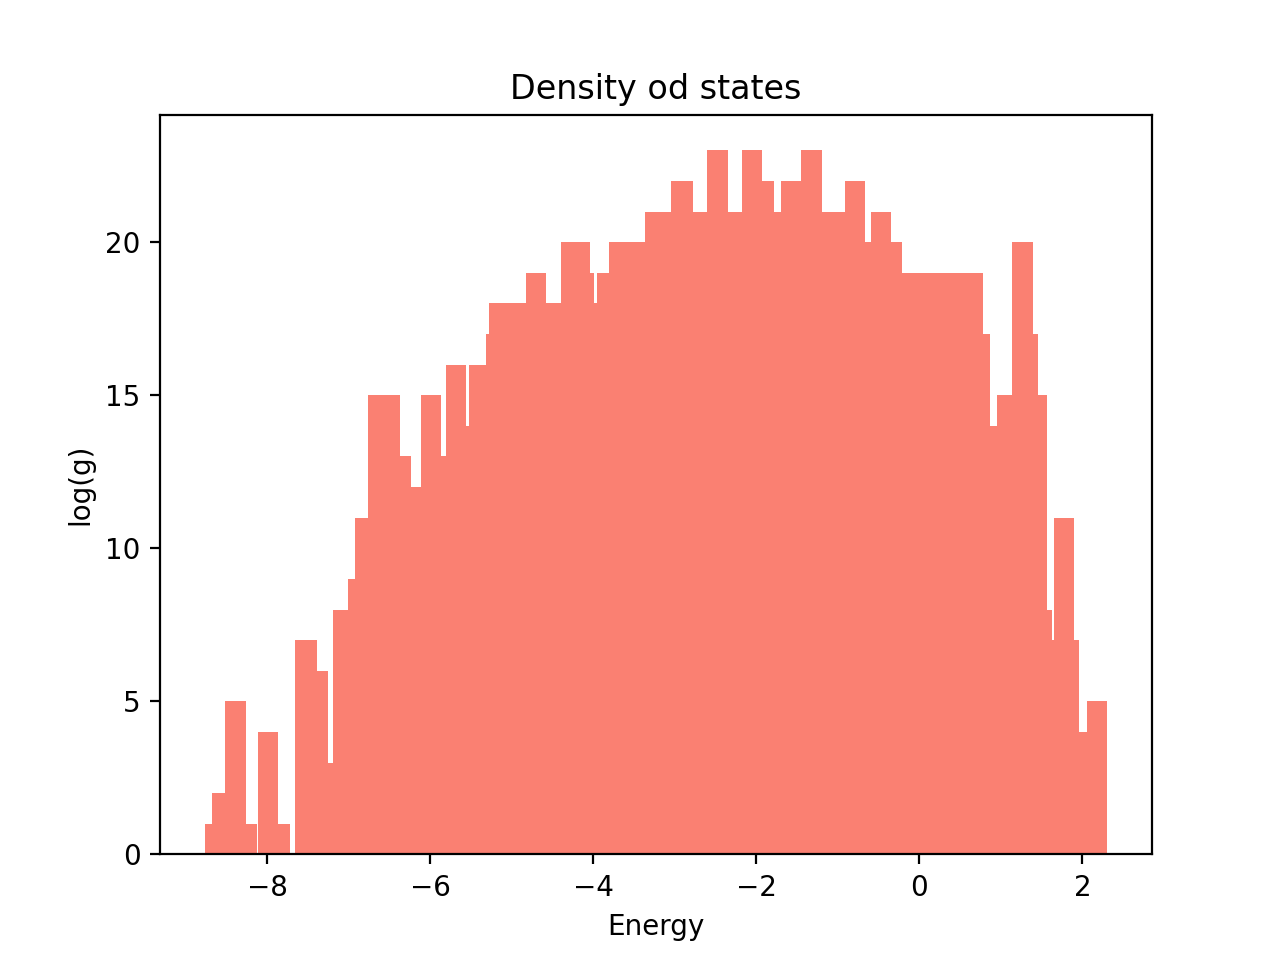

In [11]:
LNG = copy.deepcopy(lng)
GCounts = np.zeros(len(LNG),dtype=np.float)
EnergyBins = np.zeros(len(LNG),dtype=np.float)
for n,key in enumerate(sorted(LNG.keys())):
    EnergyBins[n] = key
    GCounts[n] = LNG[key]
    
plt.bar(EnergyBins,GCounts,width = 0.25, color = "salmon")    
plt.xlabel("Energy")
plt.ylabel("log(g)")
plt.title("Density od states")
plt.show()

<IPython.core.display.Javascript object>


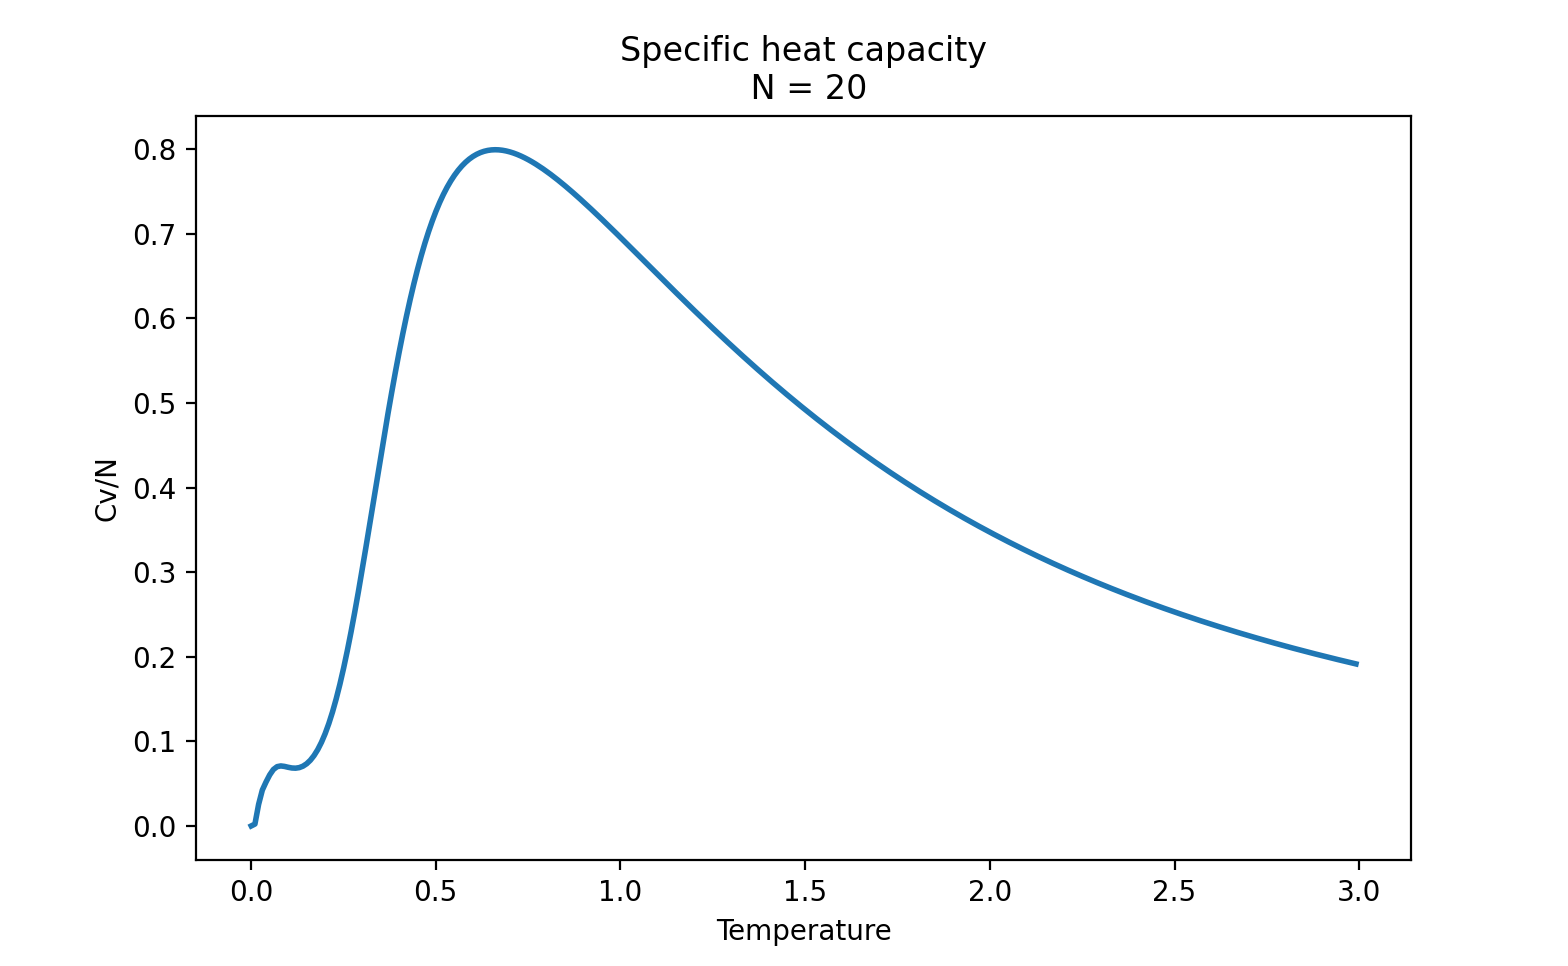

In [12]:
shift = abs(min(EnergyBins))
Energies = copy.deepcopy(EnergyBins)
for n in range(len(EnergyBins)):
    Energies[n]+=shift
temperatures = np.arange(0.001,3.0,0.01)
HC = []
Z = []
for T in temperatures:
    z = 0
    for n,e in enumerate(Energies):
        z += GCounts[n]*np.exp(-e/T)
    Z.append(z)    

HC = []
for c,T in enumerate(temperatures):
    hc = 0
    for n,e in enumerate(Energies):
        hc+=((((e**2)*np.exp(-e/T)*GCounts[n])/Z[c])- (((e*np.exp(-e/T)*GCounts[n])/Z[c])**2))
    HC.append(hc/T**2/len(Sequence))
    
plt.plot(temperatures,HC,color='tab:blue',linewidth=2.0)
plt.xlabel("Temperature")
plt.ylabel("Cv/N")
plt.title(f'Specific heat capacity\n N = {len(Sequence)}')
plt.show()

<IPython.core.display.Javascript object>


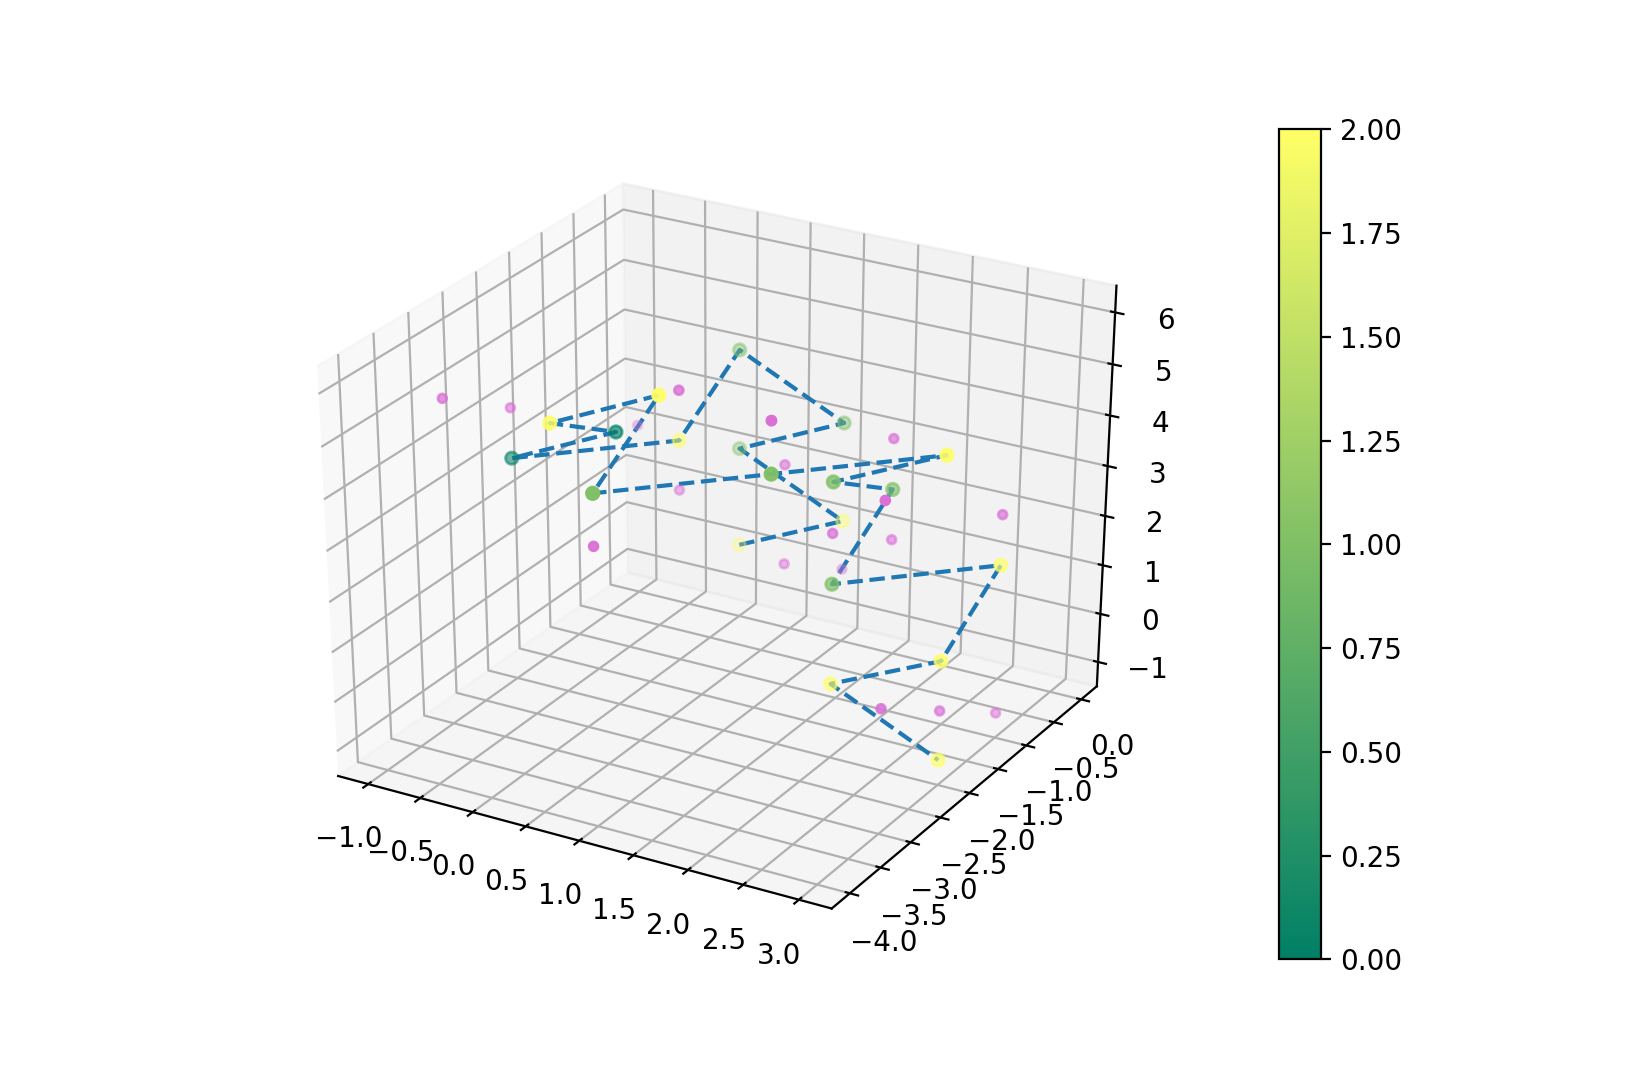

In [13]:
s1 = Configurations[0]
s2 = SideChainConfigurations[0]

fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = np.ones(len(Sequence),dtype = np.int)
ydata = np.ones(len(Sequence),dtype = np.int)
zdata = np.ones(len(Sequence),dtype = np.int)
xdata2 = np.ones(len(Sequence),dtype = np.int)
ydata2 = np.ones(len(Sequence),dtype = np.int)
zdata2 = np.ones(len(Sequence),dtype = np.int)

for n in range(len(Sequence)):
    xdata[n], ydata[n], zdata[n] = s1[n, :]
    xdata2[n], ydata2[n], zdata2[n] = s2[n,:]
p = ax.scatter3D(xdata, ydata, zdata, s = 20,c = Sequence,cmap = 'summer')
ax.scatter3D(xdata2, ydata2, zdata2, s = 10, c='orchid')
ax.plot3D(xdata, ydata, zdata,'--')
plt.colorbar(p)
plt.show()

In [ ]:
h1 = copy.deepcopy(Histogram)
print(len(h1))
HCounts = np.zeros(len(h1),dtype=np.int)
hEnergyBins = np.zeros(len(h1),dtype=np.float)
for n,key in enumerate(sorted(h1.keys())):
    hEnergyBins[n] = key
    HCounts[n] = h1[key]

plt.bar(hEnergyBins,HCounts,width=0.1)  
plt.xlabel("Energy")
plt.ylabel("Counts)")
plt.title("Histogram")
plt.show()

In [ ]:
if len(Snapshots) > 0:
    h1 = copy.deepcopy(Snapshots[0])
    print(len(h1))
    HCounts = np.zeros(len(h1),dtype=np.int)
    hEnergyBins = np.zeros(len(h1),dtype=np.float)
    for n,key in enumerate(sorted(h1.keys())):
        hEnergyBins[n] = key
        HCounts[n] = h1[key]

    plt.bar(hEnergyBins,HCounts,width=0.1)  
    plt.xlabel("Energy")
    plt.ylabel("Counts)")
    plt.title("Histogram")
    plt.show()

<IPython.core.display.Javascript object>


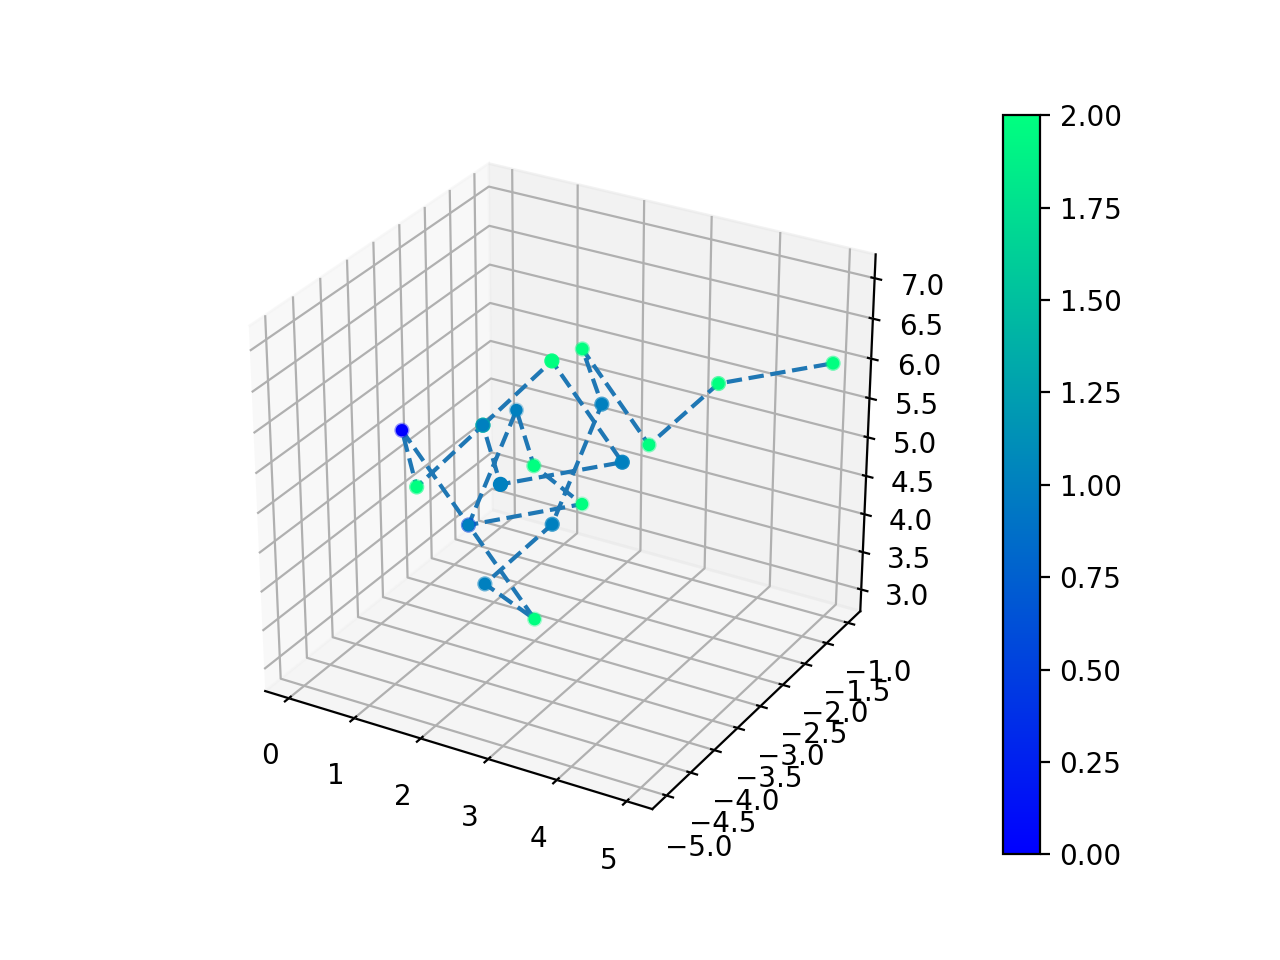

<IPython.core.display.Javascript object>


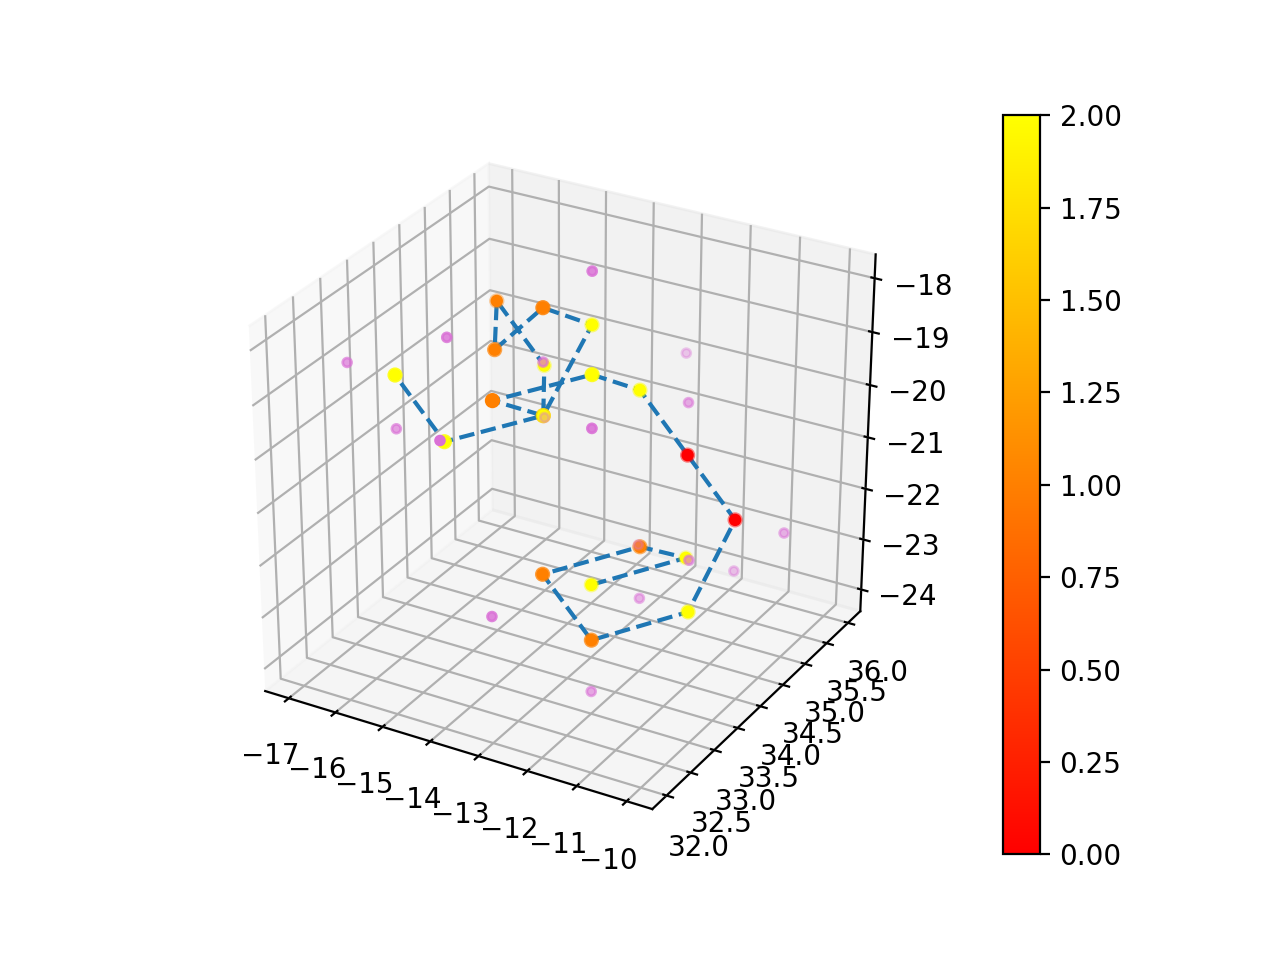

In [14]:
s1 = Configurations[50]
s2 = SideChainConfigurations[50]

fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = np.ones(len(Sequence),dtype = np.int)
ydata = np.ones(len(Sequence),dtype = np.int)
zdata = np.ones(len(Sequence),dtype = np.int)
xdata2 = np.ones(len(Sequence),dtype = np.int)
ydata2 = np.ones(len(Sequence),dtype = np.int)
zdata2 = np.ones(len(Sequence),dtype = np.int)

for n in range(len(Sequence)):
    xdata[n], ydata[n], zdata[n] = s1[n, :]
    xdata2[n], ydata2[n], zdata2[n] = s2[n,:]
p = ax.scatter3D(xdata, ydata, zdata, s = 20,c = Sequence,cmap = 'winter')
#ax.scatter3D(xdata2, ydata2, zdata2, s = 50, c='tab:blue')
ax.plot3D(xdata, ydata, zdata,'--')
plt.colorbar(p)
plt.show()

s1 = Configurations[-1]
s2 = SideChainConfigurations[-1]

fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = np.ones(len(Sequence),dtype = np.int)
ydata = np.ones(len(Sequence),dtype = np.int)
zdata = np.ones(len(Sequence),dtype = np.int)
xdata2 = np.ones(len(Sequence),dtype = np.int)
ydata2 = np.ones(len(Sequence),dtype = np.int)
zdata2 = np.ones(len(Sequence),dtype = np.int)

for n in range(len(Sequence)):
    xdata[n], ydata[n], zdata[n] = s1[n, :]
    xdata2[n], ydata2[n], zdata2[n] = s2[n,:]
p = ax.scatter3D(xdata, ydata, zdata, s = 20,c = Sequence,cmap = 'autumn')
ax.scatter3D(xdata2, ydata2, zdata2, s = 10, c='orchid')
ax.plot3D(xdata, ydata, zdata,'--')
plt.colorbar(p)
plt.show()